<h1> Possum Regression </h1>

<h1> First approach </h1>
Data set:

https://www.kaggle.com/datasets/abrambeyer/openintro-possum?datasetId=1534513&sortBy=voteCount
<h2> Introduction </h2>

An objective of this work is to consolidate and use part of the knowledge gained from the book "Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow".

Our goal is to predict the age of given possum. The problem is supervised and multiple regression type. I will use batch learning, because there is no particular need to adjust to changing data rapidly, the dataset is small and there is no continuous stream of data coming.

Root Mean Square Error (RMSE) as a performance measure is a common cost function in regression tasks, so that will be our choice.

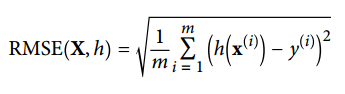

<h2> Libraries and settings</h2>

In [495]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import wasserstein_distance, uniform, truncnorm, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR, NuSVR
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

%run ml_functions.ipynb
%run custom_transformers.ipynb

np.random.seed(42)

from IPython.display import Audio
sound_file = './sound/short_sound.mp3'

<h2>Load the data <h2>

In [496]:
df = pd.read_csv('data/possum.csv')

<h3> Take a quick look </h3>

In [497]:
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [498]:
df.columns

Index(['case', 'site', 'Pop', 'sex', 'age', 'hdlngth', 'skullw', 'totlngth',
       'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly'],
      dtype='object')

In [499]:
df.shape

(104, 14)

There are 14 attributes including one dependent variable - 'age' and 104 instances. It means the dataset is very small by ML standards.

In [500]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
case        104 non-null int64
site        104 non-null int64
Pop         104 non-null object
sex         104 non-null object
age         102 non-null float64
hdlngth     104 non-null float64
skullw      104 non-null float64
totlngth    104 non-null float64
taill       104 non-null float64
footlgth    103 non-null float64
earconch    104 non-null float64
eye         104 non-null float64
chest       104 non-null float64
belly       104 non-null float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB


<h3>Some at first glance data cleaning</h3>

10 of the columns are float-type. Columns of an object type are Pop and sex. Columns of int-type are case, and site. from a dataset description, we know in reality that Pop, sex, and site are categorical attributes.

In [501]:
df["Pop"] = df["Pop"].astype('category')
df["sex"] = df["sex"].astype('category')
df["site"] = df["site"].astype('category')

We can also change 'Pop' name column to 'pop', which fits better with other column names.

In [502]:
df = df.rename(columns={"Pop":"pop"})

The next point is, case column is useless because rows have indexes.

In [503]:
del df["case"]

Now we have 10 float type and 3 category type attributes.

In column 'age' 2 entries are missing and in column footlngth 1 entry is missing. There are no missing values in other columns.

In [504]:
3 / np.product(df.shape) * 100

0.22189349112426035

The gaps in the data are insignificant (less than 1%). We could easily drop the rows in the future.

In [505]:
df.head()

,site,pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [506]:
print(df["sex"].value_counts())
print(df["pop"].value_counts())
print(df["site"].value_counts())

m    61
f    43
Name: sex, dtype: int64
other    58
Vic      46
Name: pop, dtype: int64
1    33
7    18
6    13
5    13
2    13
4     7
3     7
Name: site, dtype: int64


We can see that both 'sex' and 'pop' categorical attributes are of a binary type and both values are nearly equally distributed in them. 'site' attribute is a little bit imbalanced.

In [507]:
df.describe()

,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
count,102.000000,104.000000,104.000000,104.000000,104.000000,103.000000,104.000000,104.000000,104.000000,104.000000
mean,3.833333,92.602885,56.883654,87.088462,37.009615,68.459223,48.130769,15.046154,27.000000,32.586538
std,1.909244,3.573349,3.113426,4.310549,1.959518,4.395306,4.109380,1.050374,2.045597,2.761949
min,1.000000,82.500000,50.000000,75.000000,32.000000,60.300000,40.300000,12.800000,22.000000,25.000000
25%,2.250000,90.675000,54.975000,84.000000,35.875000,64.600000,44.800000,14.400000,25.500000,31.000000
50%,3.000000,92.800000,56.350000,88.000000,37.000000,68.000000,46.800000,14.900000,27.000000,32.500000
75%,5.000000,94.725000,58.100000,90.000000,38.000000,72.500000,52.000000,15.725000,28.000000,34.125000
max,9.000000,103.100000,68.600000,96.500000,43.000000,77.900000,56.200000,17.800000,32.000000,40.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c267e2b38>,
      dtype=object)

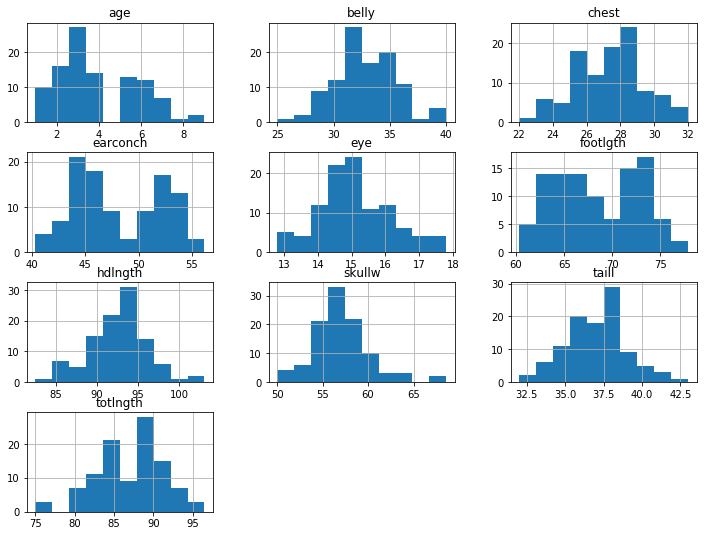

In [508]:
df.hist(figsize=(12,9))

Histograms show us that we shouldn't really be concerned about aspects such as attributes of very different scales or tail-heavy data. However, we will take a better look at these histograms later, during the preprocessing process. Additionally, we can see that data doesn't contain outliers, which is one of the factors in favor of changing rmse to another performance measure.

<h3> Test set and training set </h3>

Now, let's check if any of the attributes are highly correlated with the dependent variable. 

In [509]:
corr_matrix = df.corr()
corr_matrix["age"].sort_values(ascending=False)

age         1.000000
belly       0.354298
chest       0.334209
hdlngth     0.319022
skullw      0.285107
totlngth    0.260280
eye         0.235553
footlgth    0.126190
taill       0.118241
earconch    0.053405
Name: age, dtype: float64

No, there is no high correlation, so we don't need to be aware of sampling bias using standard random sampling.

In [510]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Now we put test_set aside and start working on train_set only.

<h2> Discover and visualize </h2>

<h3> Histograms </h3>

First, let's deduce something from the histograms of the train_set.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c267e29b0>,
      dtype=object)

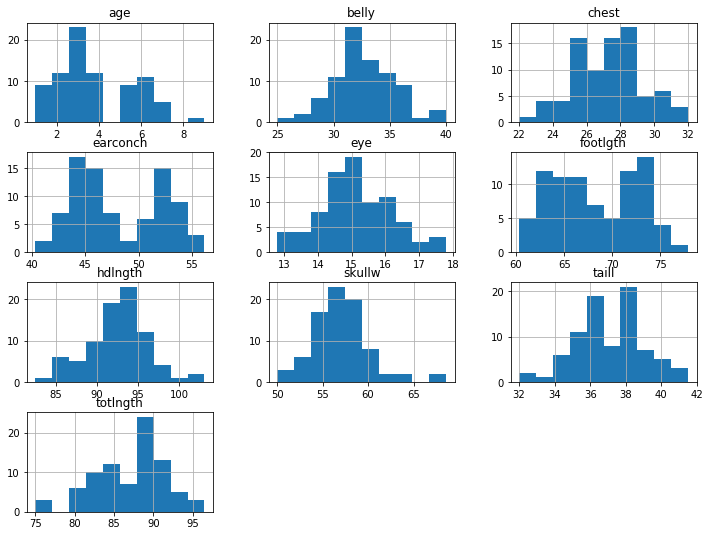

In [511]:
train_set.hist(figsize=(12,9))

Wasserstein distance is a metric in the space of probability measures, which can measure distance between histograms.

In [512]:
columns = train_set.columns

for i in range(len(train_set.columns)):
    if is_numeric_dtype(train_set[train_set.columns[i]]):
        for j in range(i+1,len(train_set.columns)):
            if is_numeric_dtype(train_set[train_set.columns[j]]):
                print('For ', train_set.columns[i], ' and ', train_set.columns[j], 'Wasserstein distance is ', wasserstein_distance(train_set[train_set.columns[i]], train_set[train_set.columns[j]]) )

For  age  and  hdlngth Wasserstein distance is  nan
For  age  and  skullw Wasserstein distance is  nan
For  age  and  totlngth Wasserstein distance is  nan
For  age  and  taill Wasserstein distance is  nan
For  age  and  footlgth Wasserstein distance is  nan
For  age  and  earconch Wasserstein distance is  nan
For  age  and  eye Wasserstein distance is  nan
For  age  and  chest Wasserstein distance is  nan
For  age  and  belly Wasserstein distance is  nan
For  hdlngth  and  skullw Wasserstein distance is  35.628915662650606
For  hdlngth  and  totlngth Wasserstein distance is  5.381927710843373
For  hdlngth  and  taill Wasserstein distance is  55.46265060240963
For  hdlngth  and  footlgth Wasserstein distance is  nan
For  hdlngth  and  earconch Wasserstein distance is  44.42168674698795
For  hdlngth  and  eye Wasserstein distance is  77.43855421686749
For  hdlngth  and  chest Wasserstein distance is  65.55903614457831
For  hdlngth  and  belly Wasserstein distance is  60.046987951807225


Pairs of histograms close to each other are: (hdlngth, totlngth), (taill, belly) and (chest, belly). Potentially we can use this information during feature engineering.

<h3> Correlations </h3>

Let's check a correlation for numeric variables.

In [513]:
train_set.corr()["age"]

age         1.000000
hdlngth     0.254740
skullw      0.192840
totlngth    0.244830
taill       0.098013
footlgth    0.045257
earconch    0.037012
eye         0.220969
chest       0.204392
belly       0.283273
Name: age, dtype: float64

As we can see, correlation levels are very low.

Now, let's check a correlation for categorical attributes (pop, sex, site). Function that we are going to use requires that data has no nans, so let's just drop them for a while.

In [514]:
train_set_new = train_set.copy()

Let's add binary columns that respond columns 'pop' and 'sex'

In [515]:
dummy = pd.get_dummies(train_set_new["pop"])
train_set_new = pd.concat((train_set_new, dummy), axis=1)
del train_set_new["other"]
train_set_new = train_set_new.rename(columns={"Vic":"pop-bin"})

dummy = pd.get_dummies(df["sex"])
train_set_new = pd.concat((train_set_new, dummy), axis=1)
del train_set_new['m']
train_set_new = train_set_new.rename(columns={"f":"sex-bin"})
train_set_new.head()

train_set_new["pop-bin"] = train_set_new["pop-bin"].astype('category')
train_set_new["sex-bin"] = train_set_new["sex-bin"].astype('category')

train_set_new = train_set_new.dropna()
train_set_new.head()

,site,pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly,pop-bin,sex-bin
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0,1.0,1
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0,1.0,1
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0,1.0,1
5,1,Vic,f,1.0,93.1,54.8,90.5,35.5,73.2,53.6,14.2,30.0,32.0,1.0,1
6,1,Vic,m,2.0,95.3,58.2,89.5,36.0,71.5,52.0,14.2,30.0,34.5,1.0,0


In [516]:
print(stats.pointbiserialr(train_set_new["pop-bin"], train_set_new["age"]))
print(stats.pointbiserialr(train_set_new["sex-bin"], train_set_new["age"]))

PointbiserialrResult(correlation=0.08370838421598424, pvalue=0.457499076789183)
PointbiserialrResult(correlation=0.097489642593006, pvalue=0.3865809886184627)


So even if assumtions of this method are fulfilled, these correlations are not significant.

For a multi categorical attribute we will try ruskal-Wallis H-test.

In [517]:
train_set_new["site"].value_counts()

1    25
7    13
6    11
5    11
2     9
4     6
3     6
Name: site, dtype: int64

In [518]:
group = [None] * 7

for i in range(1,8):
    group[i-1] = train_set_new[["age"]].where(train_set_new["site"] == i).dropna()["age"].tolist()
    print(stats.kruskal(group[i-1], train_set_new["age"]))

KruskalResult(statistic=0.3395172088593224, pvalue=0.5601080307426141)
KruskalResult(statistic=0.1417795109924597, pvalue=0.7065183074614497)
KruskalResult(statistic=0.561735433647231, pvalue=0.4535618539169247)
KruskalResult(statistic=2.005456853621326, pvalue=0.15673406872991036)
KruskalResult(statistic=1.2790622918879813, pvalue=0.2580734590616538)
KruskalResult(statistic=0.008454874681601976, pvalue=0.9267374535850667)
KruskalResult(statistic=1.136838159720179, pvalue=0.28632143298397716)


Since for every group p-value is less than 0.05, we don't reject the null hypothesis that the median of a group is the same as in train_set for each group. So, we can expect that site grouping does not explain the variance to a great extent, hence correlation is low.

<h3> Attribute Combinations </h3>

Since we have only 9 attributes describing possums body, let's just compute ratios between them.

In [519]:
train_set_new = train_set.copy()

body_columns = ['hdlngth', 'skullw', 'totlngth', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

for i in range(9):
    for j in range(i+1,9):
        new_column = body_columns[i] + " / " + body_columns[j]
        train_set_new[new_column] = train_set_new[body_columns[i]] / train_set_new[body_columns[j]]

In [520]:
corr_matrix = train_set_new.corr()
corr_matrix["age"].sort_values(ascending=False)

age                    1.000000
belly                  0.283273
hdlngth                0.254740
totlngth               0.244830
eye                    0.220969
chest                  0.204392
skullw                 0.192840
totlngth / footlgth    0.162309
totlngth / taill       0.147566
hdlngth / footlgth     0.141474
skullw / footlgth      0.120056
totlngth / earconch    0.099592
taill                  0.098013
hdlngth / earconch     0.087937
skullw / earconch      0.084262
hdlngth / taill        0.083814
skullw / taill         0.081666
footlgth               0.045257
earconch               0.037012
taill / footlgth       0.025634
taill / earconch       0.018716
hdlngth / skullw      -0.024388
skullw / totlngth     -0.024991
totlngth / eye        -0.027085
eye / chest           -0.028092
footlgth / earconch   -0.034156
skullw / eye          -0.051047
hdlngth / totlngth    -0.057181
hdlngth / eye         -0.068390
totlngth / chest      -0.074794
eye / belly           -0.091034
skullw /

Again, correlations are on very low level.

<h2> Prepare the data for ML algorithms </h2>
<h3> Data Cleaning </h3>

In [521]:
train_set_new = train_set.copy()
train_set_new = train_set_new[train_set_new['age'].notna()]
train_set_labels = train_set_new["age"].copy()
train_set_new = train_set_new.drop("age", axis=1)

Since there is only one nan label, we've just dropped it.

Most ML algorithms cannot deal with missing values and we are not sure that there won't be any missing values in new data, let's take a strategy to replace numerical missing instances with the median of an attribute.

In [522]:
imputer = SimpleImputer(strategy='median')
train_set_new_num = train_set_new.drop(["site", "pop", "sex"], axis=1)
imputer.fit(train_set_new_num)
X = imputer.transform(train_set_new_num)
train_set_new_transformed = pd.DataFrame(X, columns=train_set_new_num.columns)

Since ML algorithms prefer to work with numbers rather than with categorical attributes, we will convert them to numerical ones.

In [523]:
train_set_new_cat = train_set_new[["site", "pop", "sex"]]
cat_encoder = OneHotEncoder()

train_set_new_cat_encoded = cat_encoder.fit_transform(train_set_new_cat)

train_set_new_cat_encoded = train_set_new_cat_encoded.toarray()

In [524]:
cat_encoder.categories_

[array([1, 2, 3, 4, 5, 6, 7]),
 array(['Vic', 'other'], dtype=object),
 array(['f', 'm'], dtype=object)]

Let's create a Pipeline, to hold our transformations in a more readable way. Despite the fact that our data is very well scaled, we can additionally do standardization, because the dataset is very small and it cost almost no time.

In [525]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

num_attribs = list(train_set_new_num.columns)
cat_attribs = ["site", "pop", "sex"]

pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ("r-skewed", FunctionTransformer(func=np.log1p), ['totlngth', 'belly']),
 ])

Additionally, we did an appropriate transformation to right-skewed features. Now, we will use our transformed data.

In [526]:
train_set_new_ready = pipeline.fit_transform(train_set_new)
train_set_new_ready.shape

(82, 58)

We finished this section with a set that contains 58 columns, ready to put into a ML algorithm.

<h2> Select and train a model </h2>

In [527]:
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import cross_decomposition
from sklearn import ensemble
from sklearn import isotonic
from sklearn.neural_network import MLPRegressor

Our plan is to test as many as possible models, with some different settings, in a short time, then choose the few most promising for hyperparameter tuning, based on rmse measure for the training set and cross-validation.

Let's calculate RMSE for training data and the mean value of RMSE for Cross-Validation.

<h2> Finding promising models </h2>

<h3> Linear Models </h3>

In [528]:
%%capture --no-display
result_lm = regression_linear_models(train_set_new_ready, train_set_labels, cv=4)
result_lm = pd.DataFrame.from_dict(result_lm)
result_lm

,ARDRegression{},BayesianRidge{},ElasticNet{'selection': 'cyclic'},ElasticNet{'selection': 'random'},HuberRegressor{},Lars{},Lasso{'selection': 'cyclic'},Lasso{'selection': 'random'},LassoLars{},LinearRegression{},"LogisticRegression{'penalty': 'l1', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l1', 'solver': 'saga'}","LogisticRegression{'penalty': 'l2', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'l2', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'l2', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l2', 'solver': 'sag'}","LogisticRegression{'penalty': 'l2', 'solver': 'saga'}","LogisticRegression{'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5}","LogisticRegression{'penalty': 'none', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'none', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'none', 'solver': 'sag'}","LogisticRegression{'penalty': 'none', 'solver': 'saga'}",OrthogonalMatchingPursuit{},PassiveAggressiveRegressor{'loss': 'epsilon_insensitive'},PassiveAggressiveRegressor{'loss': 'squared_epsilon_insensitive'},RANSACRegressor{},Ridge{'solver': 'svd'},Ridge{'solver': 'lsqr'},Ridge{'solver': 'sag'},Ridge{'solver': 'cholesky'},Ridge{'solver': 'sparse_cg'},Ridge{'solver': 'saga'},"SGDRegressor{'learning_rate': 'constant', 'penalty': 'l1'}","SGDRegressor{'learning_rate': 'constant', 'penalty': 'l2'}","SGDRegressor{'learning_rate': 'constant', 'penalty': 'elasticnet'}","SGDRegressor{'learning_rate': 'optimal', 'penalty': 'l1'}","SGDRegressor{'learning_rate': 'optimal', 'penalty': 'l2'}","SGDRegressor{'learning_rate': 'optimal', 'penalty': 'elasticnet'}","SGDRegressor{'learning_rate': 'invscaling', 'penalty': 'l1'}","SGDRegressor{'learning_rate': 'invscaling', 'penalty': 'l2'}","SGDRegressor{'learning_rate': 'invscaling', 'penalty': 'elasticnet'}","SGDRegressor{'learning_rate': 'adaptive', 'penalty': 'l1'}","SGDRegressor{'learning_rate': 'adaptive', 'penalty': 'l2'}","SGDRegressor{'learning_rate': 'adaptive', 'penalty': 'elasticnet'}",TheilSenRegressor{},TweedieRegressor{'link': 'identity'},TweedieRegressor{'link': 'log'}
rmse_cv,1.936501,1.849728,1.854198,1.854542,2.576841,337226.643178,1.844538,1.844538,1.844538,8.022427,1.986954,2.064786,2.362686,2.362686,2.156346,2.246902,2.246902,2.179860,2.530378,2.357410,2.554081,2.393976,1.945627,2.294083,2.186708,15.167141,2.012011,2.009916,2.012058,2.012011,2.012109,2.009161,2.787248,2.003023,2.406257,6.379258e+13,1.780813e+14,1.124778e+14,1.944047,1.939135,1.929254,1.966376,1.949218,1.952146,8.693768,1.851942,2.114588
rmse_training,1.500612,1.720985,1.807324,1.807324,1.275551,72.090142,1.809692,1.809692,1.809692,0.850896,1.678414,1.728527,1.542092,1.542092,1.530184,1.542092,1.649094,1.637964,0.000000,0.594692,1.444080,1.485704,1.570558,2.043614,2.612285,2.601949,1.390836,1.391946,1.404288,1.390836,1.390878,1.417763,1.890971,1.990027,2.309647,1.395128e+14,3.432921e+13,1.127929e+14,1.632344,1.610927,1.596070,1.500173,1.502126,1.454201,1.070829,1.639399,1.524623


<h3> KernelRidge </h3>

In [529]:
%%capture --no-display
result_kr = regression_kernelridge(train_set_new_ready, train_set_labels, cv=4)
result_kr = pd.DataFrame.from_dict(result_kr)
result_kr

,KernelRidge 1**2,KernelRidge DotProduct(sigma_0=1),"KernelRidge ExpSineSquared(length_scale=1, periodicity=1)","KernelRidge Matern(length_scale=1, nu=1.5)","KernelRidge PairwiseKernel(gamma=1.0, metric=linear)","KernelRidge RationalQuadratic(alpha=1, length_scale=1)",KernelRidge RBF(length_scale=1),KernelRidge WhiteKernel(noise_level=1),KernelRidge linear
rmse_cv,1.842443,2.011974,15.776251,4.042328,2.011973,2.578366,4.083858,4.099670,2.011973
rmse_training,1.810247,1.390653,3.318812,2.023938,1.390648,1.218348,2.055960,4.136394,1.390648


<h3> SVM </h3>

In [530]:
%%capture --no-display
result_svm = regression_svm(train_set_new_ready, train_set_labels, cv=4)
result_svm = pd.DataFrame.from_dict(result_svm)
result_svm

,LinearSVR{'loss': 'epsilon_insensitive'},LinearSVR{'loss': 'squared_epsilon_insensitive'},NuSVR{'kernel': 'linear'},NuSVR{'kernel': 'poly'},NuSVR{'kernel': 'rbf'},NuSVR{'kernel': 'sigmoid'},SVR{'kernel': 'linear'},SVR{'kernel': 'poly'},SVR{'kernel': 'rbf'},SVR{'kernel': 'sigmoid'}
rmse_cv,2.167655,2.052190,1.916470,1.770307,1.742634,1.851783,2.133088,1.82145,1.720149,1.933953
rmse_training,1.514513,1.343105,1.476317,1.377438,1.481749,1.837184,1.496323,1.43371,1.489761,1.877357


<h3> Gaussian Process </h3>

In [531]:
%%capture --no-display
result_gpr = regression_gaussianprocess(train_set_new_ready, train_set_labels, cv=4)
result_gpr = pd.DataFrame.from_dict(result_gpr)
result_gpr

,GaussianProcessRegressor 1**2,GaussianProcessRegressor DotProduct(sigma_0=1),"GaussianProcessRegressor Matern(length_scale=1, nu=1.5)","GaussianProcessRegressor PairwiseKernel(gamma=1.0, metric=linear)","GaussianProcessRegressor RationalQuadratic(alpha=1, length_scale=1)",GaussianProcessRegressor RBF(length_scale=1),GaussianProcessRegressor WhiteKernel(noise_level=1)
rmse_cv,3.456524,8.021744,1.773059e+00,8.021249,1.705117e+00,2.039888e+00,4.099670
rmse_training,1.809692,0.850870,3.182821e-10,0.851026,2.213021e-10,4.607289e-10,4.136394


<h3> Cross Decomposition </h3>

In [532]:
%%capture --no-display
result_cd = regression_crossdecomposition(train_set_new_ready, train_set_labels, cv=4)
result_cd = pd.DataFrame.from_dict(result_cd)
result_cd

,CCA{},PLSCanonical{'algorithm': 'nipals'},PLSCanonical{'algorithm': 'svd'},PLSRegression{}
rmse_cv,1.841178,4.974416,4.974416,1.890073
rmse_training,1.788298,4.701129,4.701129,1.586375


<h3> Decision Tree </h3>

In [533]:
result_tree = regression_decisiontree(train_set_new_ready, train_set_labels, cv=4)
result_tree = pd.DataFrame.from_dict(result_tree)
result_tree

,"DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'log2'}"
rmse_cv,2.278185,2.209973,2.259751,2.342724,2.548122,2.391218,2.467299,2.360195,2.214221,2.123621,2.269739,2.591936,2.135454,2.163733,2.533221,2.494947,2.447673,2.348223,2.639917,2.277703,2.68581,2.437743,2.459738,2.683687,2.598992,2.509037,2.432315,2.527476,2.67103,2.622755,2.667901,2.889327
rmse_training,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


<h3> Ensemble Methods </h3>

In [538]:
%%capture --no-display

result_ens = regression_ensemble(train_set_new_ready, train_set_labels, cv=4)
result_ens = pd.DataFrame.from_dict(result_ens)
result_ens

,AdaBoostRegressor{'loss': 'linear'},AdaBoostRegressor{'loss': 'square'},AdaBoostRegressor{'loss': 'exponential'},BaggingRegressor{},"ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'sqrt'}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'log2'}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': None}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': 1}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 'sqrt'}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 'log2'}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': None}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 1}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'log2'}",IsolationForest{},"RandomForestRegressor{'criterion': 'mse', 'max_features': 'sqrt'}","RandomForestRegressor{'criterion': 'mse', 'max_features': 'log2'}","RandomForestRegressor{'criterion': 'mse', 'max_features': None}","RandomForestRegressor{'criterion': 'mse', 'max_features': 1}","RandomForestRegressor{'criterion': 'mae', 'max_features': 'sqrt'}","RandomForestRegressor{'criterion': 'mae',

<h3> Neural Network </h3>

In [535]:
%%capture --no-display
regression_neuralnetwork
result_nn = regression_neuralnetwork(train_set_new_ready, train_set_labels, cv=4)
result_nn = pd.DataFrame.from_dict(result_nn)
result_nn

,"MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'adam'}"
rmse_cv,2.541038,1.939891,2.039910,2.603890,1.962460,1.942471,2.532667,1.929567,2.089535,2.50669,1.969280,1.883001,2.211726,1.996911,1.882330,2.422484,1.849734,1.897464,2.301830,1.876582,2.055804,2.212011,1.936340,1.884506,2.451246,1.879909,2.077749,2.226337,1.829515,1.847804,2.379905,1.845045,1.795665,2.287506,1.785755,1.887604
rmse_training,1.105326,1.515528,1.704454,1.112845,2.421541,1.725049,1.099303,1.535270,1.742883,0.00192,1.937167,1.472853,0.001569,2.156948,1.485565,0.001793,1.756306,1.482906,0.000503,1.167922,0.764731,0.000433,1.757511,0.854387,0.000501,1.175869,0.820818,0.001034,1.692572,0.771235,0.000450,1.754491,0.713711,0.000859,1.664385,0.551754


<h3> Summary </h3>

In [539]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
result = pd.concat([result_lm, result_kr, result_svm, result_gpr, result_cd, result_tree, result_ens, result_nn] , axis=1)
result

,ARDRegression{},BayesianRidge{},ElasticNet{'selection': 'cyclic'},ElasticNet{'selection': 'random'},HuberRegressor{},Lars{},Lasso{'selection': 'cyclic'},Lasso{'selection': 'random'},LassoLars{},LinearRegression{},"LogisticRegression{'penalty': 'l1', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l1', 'solver': 'saga'}","LogisticRegression{'penalty': 'l2', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'l2', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'l2', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l2', 'solver': 'sag'}","LogisticRegression{'penalty': 'l2', 'solver': 'saga'}","LogisticRegression{'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5}","LogisticRegression{'penalty': 'none', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'none', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'none', 'solver': 'sag'}","LogisticRegression{'penalty': 'none', 'solver': 'saga'}",OrthogonalMatchingPursuit{},PassiveAggressiveRegressor{'loss': 'epsilon_insensitive'},PassiveAggressiveRegressor{'loss': 'squared_epsilon_insensitive'},RANSACRegressor{},Ridge{'solver': 'svd'},Ridge{'solver': 'lsqr'},Ridge{'solver': 'sag'},Ridge{'solver': 'cholesky'},Ridge{'solver': 'sparse_cg'},Ridge{'solver': 'saga'},"SGDRegressor{'learning_rate': 'constant', 'penalty': 'l1'}","SGDRegressor{'learning_rate': 'constant', 'penalty': 'l2'}","SGDRegressor{'learning_rate': 'constant', 'penalty': 'elasticnet'}","SGDRegressor{'learning_rate': 'optimal', 'penalty': 'l1'}","SGDRegressor{'learning_rate': 'optimal', 'penalty': 'l2'}","SGDRegressor{'learning_rate': 'optimal', 'penalty': 'elasticnet'}","SGDRegressor{'learning_rate': 'invscaling', 'penalty': 'l1'}","SGDRegressor{'learning_rate': 'invscaling', 'penalty': 'l2'}","SGDRegressor{'learning_rate': 'invscaling', 'penalty': 'elasticnet'}","SGDRegressor{'learning_rate': 'adaptive', 'penalty': 'l1'}","SGDRegressor{'learning_rate': 'adaptive', 'penalty': 'l2'}","SGDRegressor{'learning_rate': 'adaptive', 'penalty': 'elasticnet'}",TheilSenRegressor{},TweedieRegressor{'link': 'identity'},TweedieRegressor{'link': 'log'},KernelRidge 1**2,KernelRidge DotProduct(sigma_0=1),"KernelRidge ExpSineSquared(length_scale=1, periodicity=1)","KernelRidge Matern(length_scale=1, nu=1.5)","KernelRidge PairwiseKernel(gamma=1.0, metric=linear)","KernelRidge RationalQuadratic(alpha=1, length_scale=1)",KernelRidge RBF(length_scale=1),KernelRidge WhiteKernel(noise_level=1),KernelRidge linear,LinearSVR{'loss': 'epsilon_insensitive'},LinearSVR{'loss': 'squared_epsilon_insensitive'},NuSVR{'kernel': 'linear'},NuSVR{'kernel': 'poly'},NuSVR{'kernel': 'rbf'},NuSVR{'kernel': 'sigmoid'},SVR{'kernel': 'linear'},SVR{'kernel': 'poly'},SVR{'kernel': 'rbf'},SVR{'kernel': 'sigmoid'},GaussianProcessRegressor 1**2,GaussianProcessRegressor DotProduct(sigma_0=1),"GaussianProcessRegressor Matern(length_scale=1, nu=1.5)","GaussianProcessRegressor PairwiseKernel(gamma=1.0, metric=linear)","GaussianProcessRegressor RationalQuadratic(alpha=1, length_scale=1)",GaussianProcessRegressor RBF(length_scale=1),GaussianProcessRegressor WhiteKernel(noise_level=1),CCA{},PLSCanonical{'algorithm': 'nipals'},PLSCanonical{'algorithm': 'svd'},PLSRegression{},"DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'b

Somehow we have to decide to continue working with a few models. The models aren't good at the moment. Some of them overfit (cv error is high, training error low), while others underfit (validation and training error high) data. In fact, we don't want to prevent underfitting yet. To do it we should select models with more parameters (we've tested a lot of models), find better features (we've done some attribute combinations), or reduce the regularization hyperparameter, which is harder than trying to prevent overfitting in other models. At first, we will prevent overfitting by reducing the number of attributes in the training data for a few models with the best rmse_cv result.

In [540]:
result.loc['rmse_cv'].sort_values().head(30)

GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'auto'}      1.648143
ExtraTreesRegressor{'criterion': 'mae', 'max_features': 1}                                         1.661700
ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'log2'}                                    1.663529
GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'log2'}                1.663822
GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': None}        1.667168
RandomForestRegressor{'criterion': 'mse', 'max_features': 'sqrt'}                                  1.668378
GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'log2'}               1.679877
ExtraTreesRegressor{'criterion': 'mse', 'max_features': 1}                                         1.682883
GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'sqrt'}      1.682952
GradientBoostingRegressor{'c

Assuming our approach, let's prevent overfitting for GradientBoostingRegressor, ExtraTreesRegressor, and RandomForestRegressor.

<h2> Fine-tuning </h2>

<h3> This chapter has been moved to fine_tuning.ipynb. </h3>

<h2> Evaluate on the test set </h2>

In [478]:
X, y = train_set_new_ready, train_set_labels

test_set_new = test_set.copy()
test_set_new = test_set_new[test_set_new['age'].notna()]
test_set_labels = test_set_new["age"].copy()
test_set_new = test_set_new.drop("age", axis=1)

test_set_new_ready = pipeline.transform(test_set_new)
test_set_new_ready.shape

X_test, y_test = test_set_new_ready, test_set_labels

In [479]:
distributions = { 'learning_rate':[0.1],
                  'n_estimators': [49],
                  'max_depth': [1],
                  'min_child_weight': [4],
                  'gamma': [0.51],
                  'subsample': [0.8],
                  'colsample_bytree': [0.68],
                  'reg_alpha': [0.0005],
                  'reg_lambda': [3.62],
                }

XGBRegressor = RandomizedSearchCV(XGBRegressor(), distributions, n_iter=1, random_state=42)

XGBRegressor.fit(X, y)

final_predictions = XGBRegressor.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2.0231537698587716

In [480]:
distributions = { 'n_estimators': [21],
                  'max_features': [6],
                  'min_samples_split': [8],
                  'max_depth': [9],
                  'max_leaf_nodes': [None],
                  'max_samples': [None],
                }

XGBRegressor = RandomizedSearchCV(ensemble.ExtraTreesRegressor(), distributions, n_iter=1, random_state=42)

XGBRegressor.fit(X, y)

final_predictions = XGBRegressor.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2.059015083770992

In [481]:
distributions = { 'n_estimators': [43],
                  'max_features': [4],
                  'max_depth': [5],
                  'max_leaf_nodes': [4],
                  'max_samples': [0.9],
                }

XGBRegressor = RandomizedSearchCV(ensemble.RandomForestRegressor(), distributions, n_iter=1, random_state=42)

XGBRegressor.fit(X, y)

final_predictions = XGBRegressor.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

2.054452273486053

<h2> Summary </h2>

An obtained solution is not as good as for a train set, because of overfitting. We could upgrade our project on many stages, f.e.:

- try other data transformations,

- try other ml models,

- do a feature selection manually,

- delve into the theory of selected models.

I am satisfied with the functions written, but as well as the dataset structure, they have to be described much better.

In spite of all this, the main assumption has been fulfilled - use the knowledge from the book in a practical project.

<h1> Second Approach </h1>

- As we remember we have only ~0.22% missing values in our dataset. This time we will drop them.

- Since age, so a target value, is an attribute, to which population is normally distributed, it should be a good idea to transform other features to have this distribution, because some models have this assumption to predict well. We can do this using Box-Cox transformation.

- Use of LabelEncoder() instead of OneHotEncoder() transformation seems to be a better option for a binary variables.

<h3> Prepare the data for ML algorithms </h3>

Drop nans.

In [376]:
df2 = df.dropna()

In [377]:
train_set, test_set = train_test_split(df2, test_size=0.2, random_state=42)

In [378]:
train_set_new = train_set.copy()
train_set_labels = train_set_new["age"].copy()
train_set_new = train_set_new.drop("age", axis=1)

In [379]:
train_set_new.head()

,site,pop,sex,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
92,7,other,m,89.2,54.0,82.0,38.0,63.8,44.9,12.8,24.0,31.0
26,1,Vic,f,90.5,54.5,85.0,35.0,70.3,50.8,14.2,23.0,28.0
44,2,Vic,m,90.7,55.9,81.0,34.0,71.5,54.0,14.6,27.0,31.5
73,6,other,f,88.7,52.0,83.0,38.0,61.5,45.9,14.7,26.0,34.0
15,1,Vic,m,91.6,56.0,86.0,34.5,73.0,51.4,14.4,28.0,32.0


LabelEncoder transformation for binary variables

In [380]:
train_set_new['pop'] = LabelEncoder().fit_transform(train_set_new['pop'])
train_set_new['sex'] = LabelEncoder().fit_transform(train_set_new['sex'])

Pipeline:

- Box-Cox transformation for numerical variables

- OneHotEncoder transformation for non-binary categorical variable "site"

In [381]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('boxcox_transformer',PowerTransformer(method='box-cox')),
    ('std_scaler', StandardScaler()),
    ])

cat_attribs = ["pop", "sex"] 

pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", FunctionTransformer() , cat_attribs),
 ("site", OneHotEncoder() , ["site"])
 ])

In [382]:
train_set_new_ready = pipeline.fit_transform(train_set_new)
train_set_new_ready.shape

(80, 18)

<h2> Finding promising models </h2>

<h3> Linear Models </h3>

In [383]:
%%capture --no-display
result_lm = regression_linear_models(train_set_new_ready, train_set_labels, cv=4)
result_lm = pd.DataFrame.from_dict(result_lm)
result_lm

,ARDRegression{},BayesianRidge{},ElasticNet{'selection': 'cyclic'},ElasticNet{'selection': 'random'},HuberRegressor{},Lars{},Lasso{'selection': 'cyclic'},Lasso{'selection': 'random'},LassoLars{},LinearRegression{},"LogisticRegression{'penalty': 'l1', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l1', 'solver': 'saga'}","LogisticRegression{'penalty': 'l2', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'l2', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'l2', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l2', 'solver': 'sag'}","LogisticRegression{'penalty': 'l2', 'solver': 'saga'}","LogisticRegression{'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5}","LogisticRegression{'penalty': 'none', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'none', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'none', 'solver': 'sag'}","LogisticRegression{'penalty': 'none', 'solver': 'saga'}",OrthogonalMatchingPursuit{},PassiveAggressiveRegressor{'loss': 'epsilon_insensitive'},PassiveAggressiveRegressor{'loss': 'squared_epsilon_insensitive'},RANSACRegressor{},Ridge{'solver': 'svd'},Ridge{'solver': 'cholesky'},Ridge{'solver': 'lsqr'},Ridge{'solver': 'sparse_cg'},Ridge{'solver': 'sag'},Ridge{'solver': 'saga'},"SGDRegressor{'penalty': 'l1', 'learning_rate': 'constant'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'optimal'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'invscaling'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'adaptive'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'constant'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'optimal'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'invscaling'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'adaptive'}","SGDRegressor{'penalty': 'elasticnet', 'learning_rate': 'adaptive'}",TheilSenRegressor{},TweedieRegressor{'link': 'identity'},TweedieRegressor{'link': 'log'}
rmse_cv,1.925800,1.764411,1.839459,1.839461,1.976364,2.062607,1.836946,1.836946,1.836946,1.963329,2.142486,2.201350,2.354799,2.354799,2.291492,2.354799,2.354799,2.279166,2.404485,2.283792,2.287870,2.346016,1.966288,2.526588,2.616513,2.833596,1.910919,1.910919,1.912833,1.911279,1.911610,1.911408,1.966193,4.380913e+13,1.904416,1.940260,1.929307,2.959083e+13,1.908288,1.948783,1.933311,1.925361,1.756683,1.922512
rmse_training,1.620884,1.658667,1.792323,1.792322,1.553883,1.524019,1.841832,1.841832,1.841832,1.524019,1.877498,1.774824,1.541104,1.541104,1.592953,1.541104,1.541104,1.713914,1.289380,1.322876,1.627882,1.643168,1.721259,2.252394,1.975341,2.795742,1.529922,1.529922,1.529963,1.529926,1.530134,1.530438,1.561183,7.309513e+12,1.582025,1.555164,1.542355,9.130164e+12,1.583032,1.541831,1.561280,1.562989,1.658128,1.591196


<h3> KernelRidge </h3>

In [384]:
%%capture --no-display
result_kr = regression_kernelridge(train_set_new_ready, train_set_labels, cv=4)
result_kr = pd.DataFrame.from_dict(result_kr)
result_kr

,KernelRidge 1**2,KernelRidge DotProduct(sigma_0=1),"KernelRidge ExpSineSquared(length_scale=1, periodicity=1)","KernelRidge Matern(length_scale=1, nu=1.5)","KernelRidge PairwiseKernel(gamma=1.0, metric=linear)","KernelRidge RationalQuadratic(alpha=1, length_scale=1)",KernelRidge RBF(length_scale=1),KernelRidge WhiteKernel(noise_level=1),KernelRidge linear
rmse_cv,1.837414,1.925657,12.392623,3.012458,1.987111,1.796029,3.385675,4.206408,1.987111
rmse_training,1.842425,1.535960,12.301448,1.430961,1.566514,0.988472,1.638930,4.211591,1.566514


<h3> SVM </h3>

In [385]:
%%capture --no-display
result_svm = regression_svm(train_set_new_ready, train_set_labels, cv=4)
result_svm = pd.DataFrame.from_dict(result_svm)
result_svm

,LinearSVR{'loss': 'epsilon_insensitive'},LinearSVR{'loss': 'squared_epsilon_insensitive'},NuSVR{'kernel': 'linear'},NuSVR{'kernel': 'poly'},NuSVR{'kernel': 'rbf'},NuSVR{'kernel': 'sigmoid'},SVR{'kernel': 'linear'},SVR{'kernel': 'poly'},SVR{'kernel': 'rbf'},SVR{'kernel': 'sigmoid'}
rmse_cv,1.970835,1.941048,1.926842,1.766412,1.662558,1.810243,1.938387,1.741310,1.643805,1.836938
rmse_training,1.628774,1.528396,1.566892,1.371323,1.384141,1.868678,1.601394,1.329835,1.338714,1.871563


<h3> Gaussian Process </h3>

In [386]:
%%capture --no-display
result_gpr = regression_gaussianprocess(train_set_new_ready, train_set_labels, cv=4)
result_gpr = pd.DataFrame.from_dict(result_gpr)
result_gpr

,GaussianProcessRegressor 1**2,GaussianProcessRegressor DotProduct(sigma_0=1),"GaussianProcessRegressor Matern(length_scale=1, nu=1.5)","GaussianProcessRegressor PairwiseKernel(gamma=1.0, metric=linear)","GaussianProcessRegressor RationalQuadratic(alpha=1, length_scale=1)",GaussianProcessRegressor RBF(length_scale=1),GaussianProcessRegressor WhiteKernel(noise_level=1)
rmse_cv,2.094000,1.963311,1.675114e+00,1.963345,1.617345e+00,2.034742e+00,4.206408
rmse_training,6.960603,1.524021,3.428084e-10,1.524009,2.205800e-10,5.806569e-10,4.211591


<h3> Cross Decomposition </h3>

In [387]:
%%capture --no-display
result_cd = regression_crossdecomposition(train_set_new_ready, train_set_labels, cv=4)
result_cd = pd.DataFrame.from_dict(result_cd)
result_cd

,CCA{},PLSCanonical{'algorithm': 'nipals'},PLSCanonical{'algorithm': 'svd'},PLSRegression{}
rmse_cv,2.006879,3.324558,3.324558,1.874215
rmse_training,1.528898,3.332586,3.332586,1.600912


<h3> Decision Tree </h3>

In [388]:
result_tree = regression_decisiontree(train_set_new_ready, train_set_labels, cv=4)
result_tree = pd.DataFrame.from_dict(result_tree)
result_tree

,"DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mae', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'log2'}"
rmse_cv,2.154528,2.113091,2.259428,2.454249,2.546761,2.216358,2.397858,2.223354,2.052504,2.08888,2.305229,2.385553,2.223224,2.498669,2.185742,2.421878,2.270406,2.378847,2.158439,2.354087,2.545623,2.397803,2.221584,2.718268,2.413965,2.701496,2.45991,2.387974,2.283737,2.490337,2.174629,2.753912
rmse_training,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000


<h3> Ensemble Methods </h3>

In [389]:
%%capture --no-display

result_ens = regression_ensemble(train_set_new_ready, train_set_labels, cv=4)
result_ens = pd.DataFrame.from_dict(result_ens)
result_ens

,AdaBoostRegressor{'loss': 'linear'},AdaBoostRegressor{'loss': 'square'},AdaBoostRegressor{'loss': 'exponential'},BaggingRegressor{},"ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'sqrt'}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 'sqrt'}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'log2'}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 'log2'}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': None}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': None}","ExtraTreesRegressor{'criterion': 'mse', 'max_features': 1}","ExtraTreesRegressor{'criterion': 'mae', 'max_features': 1}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'ls', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'lad', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'huber', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': None}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'friedman_mse', 'loss': 'quantile', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'ls', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'lad', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'huber', 'max_features': 'log2'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': None}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'auto'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'sqrt'}","GradientBoostingRegressor{'criterion': 'mse', 'loss': 'quantile', 'max_features': 'log2'}",IsolationForest{},"RandomForestRegressor{'criterion': 'mse', 'max_features': 'sqrt'}","RandomForestRegressor{'criterion': 'mse', 'max_features': 'log2'}","RandomForestRegressor{'criterion': 'mse', 'max_features': None}","RandomForestRegressor{'criterion': 'mse', 'max_features': 1}","RandomForestRegressor{'criterion': 'mae', 'max_features': 'sqrt'}","RandomForestRegressor{'criterion': 'mae',

<h3> Neural Network </h3>

In [390]:
%%capture --no-display
regression_neuralnetwork
result_nn = regression_neuralnetwork(train_set_new_ready, train_set_labels, cv=4)
result_nn = pd.DataFrame.from_dict(result_nn)
result_nn

,"MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'identity', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'logistic', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'constant', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'invscaling', 'solver': 'adam'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'lbfgs'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'sgd'}","MLPRegressor {'activation': 'tanh', 'learning_rate': 'adaptive', 'solver': 'adam'}"
rmse_cv,1.963121,1.883178,1.978460,1.963126,3.304924,1.961872,1.963303,1.911270,1.995165,2.346214,2.007539,1.741033,2.156759,2.103564,1.733593,2.454860,1.813330,1.736406,2.566203,1.852692,1.957774,2.631801,3.518410,1.957274,2.458519,1.822328,1.913224,2.287775,1.815395,1.905225,2.425059,3.642335,1.907730,2.663011,1.862716,1.898923
rmse_training,1.524019,1.603959,1.581808,1.524020,3.773842,1.595383,1.524019,1.657716,1.597518,0.009478,2.016008,1.605800,0.007197,2.225352,1.609267,0.005139,1.816232,1.608751,0.000825,1.450455,1.302300,0.000820,3.418295,1.426955,0.000647,1.456543,1.318705,0.001184,1.524270,1.447361,0.000831,3.575890,1.393522,0.001374,1.550584,1.450019


<h3> Summary </h3>

In [391]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
result = pd.concat([result_lm, result_kr, result_svm, result_gpr, result_cd, result_tree, result_ens, result_nn] , axis=1)
result

,ARDRegression{},BayesianRidge{},ElasticNet{'selection': 'cyclic'},ElasticNet{'selection': 'random'},HuberRegressor{},Lars{},Lasso{'selection': 'cyclic'},Lasso{'selection': 'random'},LassoLars{},LinearRegression{},"LogisticRegression{'penalty': 'l1', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l1', 'solver': 'saga'}","LogisticRegression{'penalty': 'l2', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'l2', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'l2', 'solver': 'liblinear'}","LogisticRegression{'penalty': 'l2', 'solver': 'sag'}","LogisticRegression{'penalty': 'l2', 'solver': 'saga'}","LogisticRegression{'penalty': 'elasticnet', 'solver': 'saga', 'l1_ratio': 0.5}","LogisticRegression{'penalty': 'none', 'solver': 'newton-cg'}","LogisticRegression{'penalty': 'none', 'solver': 'lbfgs'}","LogisticRegression{'penalty': 'none', 'solver': 'sag'}","LogisticRegression{'penalty': 'none', 'solver': 'saga'}",OrthogonalMatchingPursuit{},PassiveAggressiveRegressor{'loss': 'epsilon_insensitive'},PassiveAggressiveRegressor{'loss': 'squared_epsilon_insensitive'},RANSACRegressor{},Ridge{'solver': 'svd'},Ridge{'solver': 'cholesky'},Ridge{'solver': 'lsqr'},Ridge{'solver': 'sparse_cg'},Ridge{'solver': 'sag'},Ridge{'solver': 'saga'},"SGDRegressor{'penalty': 'l1', 'learning_rate': 'constant'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'optimal'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'invscaling'}","SGDRegressor{'penalty': 'l1', 'learning_rate': 'adaptive'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'constant'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'optimal'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'invscaling'}","SGDRegressor{'penalty': 'l2', 'learning_rate': 'adaptive'}","SGDRegressor{'penalty': 'elasticnet', 'learning_rate': 'adaptive'}",TheilSenRegressor{},TweedieRegressor{'link': 'identity'},TweedieRegressor{'link': 'log'},KernelRidge 1**2,KernelRidge DotProduct(sigma_0=1),"KernelRidge ExpSineSquared(length_scale=1, periodicity=1)","KernelRidge Matern(length_scale=1, nu=1.5)","KernelRidge PairwiseKernel(gamma=1.0, metric=linear)","KernelRidge RationalQuadratic(alpha=1, length_scale=1)",KernelRidge RBF(length_scale=1),KernelRidge WhiteKernel(noise_level=1),KernelRidge linear,LinearSVR{'loss': 'epsilon_insensitive'},LinearSVR{'loss': 'squared_epsilon_insensitive'},NuSVR{'kernel': 'linear'},NuSVR{'kernel': 'poly'},NuSVR{'kernel': 'rbf'},NuSVR{'kernel': 'sigmoid'},SVR{'kernel': 'linear'},SVR{'kernel': 'poly'},SVR{'kernel': 'rbf'},SVR{'kernel': 'sigmoid'},GaussianProcessRegressor 1**2,GaussianProcessRegressor DotProduct(sigma_0=1),"GaussianProcessRegressor Matern(length_scale=1, nu=1.5)","GaussianProcessRegressor PairwiseKernel(gamma=1.0, metric=linear)","GaussianProcessRegressor RationalQuadratic(alpha=1, length_scale=1)",GaussianProcessRegressor RBF(length_scale=1),GaussianProcessRegressor WhiteKernel(noise_level=1),CCA{},PLSCanonical{'algorithm': 'nipals'},PLSCanonical{'algorithm': 'svd'},PLSRegression{},"DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'best', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': None}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'sqrt'}","DecisionTreeRegressor {'criterion': 'mse', 'splitter': 'random', 'max_features': 'log2'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': None}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_features': 'auto'}","DecisionTreeRegressor {'criterion': 'friedman_mse', 'splitter': 'best', 'max_fea

In [392]:
result.loc['rmse_cv'].sort_values().head(30)

GaussianProcessRegressor RationalQuadratic(alpha=1, length_scale=1)                                1.617345
SVR{'kernel': 'rbf'}                                                                               1.643805
RandomForestRegressor{'criterion': 'mse', 'max_features': 'sqrt'}                                  1.649731
RandomForestRegressor{'criterion': 'mae', 'max_features': 'sqrt'}                                  1.650300
NuSVR{'kernel': 'rbf'}                                                                             1.662558
RandomForestRegressor{'criterion': 'mae', 'max_features': 1}                                       1.668262
RandomForestRegressor{'criterion': 'mse', 'max_features': 1}                                       1.674186
GaussianProcessRegressor Matern(length_scale=1, nu=1.5)                                            1.675114
ExtraTreesRegressor{'criterion': 'mse', 'max_features': 'sqrt'}                                    1.675599
ExtraTreesRegressor{'criteri

Let's prevent overfitting for GaussianProcessRegressor, RandomForestRegressor and SVR.

<h2> Fine-tuning </h2>

<h3> This chapter has been moved to fine_tuning.ipynb. </h3>

<h2> Evaluate on the test set </h2>

In [414]:
X, y = train_set_new_ready, train_set_labels

test_set_new = test_set.copy()
test_set_new = test_set_new[test_set_new['age'].notna()]
test_set_labels = test_set_new["age"].copy()
test_set_new = test_set_new.drop("age", axis=1)

test_set_new['pop'] = LabelEncoder().fit_transform(test_set_new['pop'])
test_set_new['sex'] = LabelEncoder().fit_transform(test_set_new['sex'])

test_set_new_ready = pipeline.transform(test_set_new)
test_set_new_ready.shape

X_test, y_test = test_set_new_ready, test_set_labels

In [415]:
distributions = { 'n_estimators': [30],
                  'max_features': [4],
                  'max_depth': [3],
                  'max_leaf_nodes': [7],
                  'max_samples': [0.9],
                }

RandomForestRegressor = RandomizedSearchCV(RandomForestRegressor(), distributions, n_iter=1, random_state=42)

RandomForestRegressor.fit(X, y)

final_predictions = RandomForestRegressor.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

1.7877550935512732

In [429]:
distributions = { 'kernel': ['rbf'],
                  'gamma': [0.1],
                  'C': [1],
                }

SVR = RandomizedSearchCV(SVR(), distributions, n_iter=1, random_state=42)

SVR.fit(X, y)

final_predictions = SVR.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

1.9269077345448156

In [430]:
distributions = { 'kernel': ['rbf'],
                  'nu': [0.8],
                  'gamma': [0.1],
                  'C': [1],
                }

NuSVR = RandomizedSearchCV(NuSVR(), distributions, n_iter=1, random_state=42)

NuSVR.fit(X, y)

final_predictions = NuSVR.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

1.917495104275013

<h2> Summary </h2>

Generally, models of this approach predict better than models from the first approach. A better result was probably obtained mainly thanks to box-cox transformation. 
A RandomForestRegressor predicts much better than other trained models, which rmse for test data is ~1.788. 

<h2> Project conclusions </h2>

- It's worth spending some time searching for a guide to hyperparameter tuning for a specific model.

- Properly chosen data transformations may significantly boost model performance.

- When training a model, set a cell to play a sound if compiled.

<h2> Bibliography </h2>

https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365

https://scikit-learn.org/stable/supervised_learning.html

https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error

https://www.analyticsvidhya.com/blog/2021/05/feature-transformations-in-data-science-a-detailed-walkthrough/

https://machinelearningmastery.com/calculate-feature-importance-with-python/

https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

https://medium.com/@radoslaw.bialowas/box-cox-transformation-explained-da8450295668

https://machinelearningmastery.com/extra-trees-ensemble-with-python/

https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fhyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167